# infos

In [ ]:
# Version 1.4

# Modèle basé sur les 10 espèces les plus représentées du jeu de données.
# Images triées : Ok, choix possible
# Undersampling : Ok, choix possible
# Echantillonage : ok, choix possible

### Changelogs :

v1.4 :
- Meilleure prise en charge de la sauvegarde du modèle et de son historique d'entrainement
- MaJ variables relatives à la fonction config_env()
- Ajout de commentaires dans le code
- Import des librairies déplacées : Appelées au fur et à mesure
- Ajout d'une partie évaluation du modèle (permet d'évaluer à chaud après entrainement


v1.3 :
- Modification de la cellule de configuration pour la rendre plus interactive
- Certains noms de variables ont été modifiés pour une meilleure compéhrension
- Les fonctions perosnnalisées sont maintenant importées à partir d'une librairie construite 'fonctions' et 'config'


v1.2 :
- Ajout d'une fonction undersample pour équilibrer les observations
- La variable history (entrainement du modèle) est maintenant sauvegardée pour être exploitée dans d'autres notebooks
- Il est maintenant possible de définir en début de notebook :
    - Le csv utilisé (avec ou sans tri des images poubelles)
    - les données (full ou en echantillon avec choix de la taille)
    - L'undersampling (avec ou sans)

v1.1 :
- Nettoyage du code pour livraison projet
- Amélioration du modèle, entrainement sous format v1.1


v1.0 :
- Itération d'un modèle avec les images non triées et triées.
- Les modèles sont enregistrés sous format V1 pour tests ultérieurs

# Configuration Notebook

### Environnement colab uniquement

In [1]:
# Executer uniquement cette cellule : Si environnement google Colab
print('Montage du lecteur Gdrive')
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/SAS/Jul23_bds_champignons/notebooks')

Montage du lecteur Gdrive
Mounted at /content/drive


### Config

In [2]:
from config import config_env
model_name, history_path, model_path, data_path, data_size, chemin_images, pourcentage_echantillon, undersampling, generator_choice, work_env = config_env()

# Dimensions des images à traiter et des batchs
img_dim = (224,224)
img_shape = (224,224,3)
batch_size = 64

Préciser nom à donner au modèle:V2

 Preciser le fichier de données à utiliser :
1. 10 classes, 64k images, non triées
2. 10 classes, 60k images, triées

 Entrez le numéro correspondant au fichier de données choisi : 2
Selection : 10 classes, 60k images, triées

 L'execution porte sur les données complètes ou un echantillon aléatoire des données ?:
1. Donnée complètes
2. Echantillon

 Entrez le numéro correspondant au choix: 1
Selection : Toutes les données

 Les données doivent-elles équilibrées ? (un undersampling sera executé):
1. AVEC undersampling
2. SANS undersampling

 Entrez le numéro correspondant au choix: 1
Selection : Avec undersampling

 Preciser generateur d'images à u'itliser:
1. Keras generator
2. Tensorflow Dataset (K.O)

 Entrez le numéro correspondant au choix: 1
Keras generator

 Preciser l'environnement de travail :
1. Ma machine
2. Google Colab

 Entrez le numéro correspondant à l'environnement choisi : 2
Environnement : Google Colab 
 Les images seront decompress

In [3]:
if work_env == '2':

  # Importer les images en format .zip
  #from google.colab import files
  #files.upload()

  # Dezipper le fichier images dans Colab
  !unzip '/content/drive/MyDrive/SAS/images.zip' -d '/images'

else:
    print("L'environnement choisi n'est pas Google Colab, aucune modification apportée dans les chemins fichiers.")

Streaming output truncated to the last 5000 lines.
  inflating: /images/images/672562.jpg  
  inflating: /images/images/672563.jpg  
  inflating: /images/images/672564.jpg  
  inflating: /images/images/67257.jpg  
  inflating: /images/images/672570.jpg  
  inflating: /images/images/67258.jpg  
  inflating: /images/images/672580.jpg  
  inflating: /images/images/672584.jpg  
  inflating: /images/images/672585.jpg  
  inflating: /images/images/672586.jpg  
  inflating: /images/images/672587.jpg  
  inflating: /images/images/67259.jpg  
  inflating: /images/images/672602.jpg  
  inflating: /images/images/67261.jpg  
  inflating: /images/images/67264.jpg  
  inflating: /images/images/672656.jpg  
  inflating: /images/images/672657.jpg  
  inflating: /images/images/672664.jpg  
  inflating: /images/images/672665.jpg  
  inflating: /images/images/672666.jpg  
  inflating: /images/images/672667.jpg  
  inflating: /images/images/672668.jpg  
  inflating: /images/images/672703.jpg  
  inflating

# Librairies générales du notebook

In [4]:
# Librairies générales servant dans le notebook
import pandas as pd
import numpy as np
import tensorflow as tf


# Librairie de fonctions personnalisées
from fonctions_data import import_df, controle_presence_fichiers, undersampling_df

# Callbacks

### EarlyStopping

In [5]:
# earlystopping défini pour réduire le temps d'entrainement si l'accuracy n'évolue plus.
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0.05,
                               patience = 3,
                               verbose = 1,
                               mode = 'auto',
                               restore_best_weights = True)

### Reduce LearningRate

In [6]:
# Reduction du learning Rate
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduceLR = ReduceLROnPlateau(monitor = 'val_loss',
                             min_delta = 0.01,
                             patience = 3,
                             factor = 0.15,
                             cooldown = 5,
                             verbose = 1)

### Checkpoint

In [7]:
# Enregistrement du modèle en cas d'amélioration lors de l'entrainement, ne conserve que la meilleure itération
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='../model/checkpoint_model',
                             monitor='val_accuracy',
                             save_best_only=True, verbose=1)

### Timer

In [8]:
# Suivi du temps d'entrainement
from timeit import default_timer as timer
from tensorflow.keras.callbacks import Callback


class TimingCallback(Callback):
    def __init__(self):
        super().__init__()
        self.logs = []

    def on_epoch_begin(self, epoch, logs=None):
        self.starttime = timer()

    def on_epoch_end(self, epoch, logs=None):
        endtime = timer()
        elapsed_time = endtime - self.starttime
        self.logs.append(elapsed_time)
        print(f"Epoch {epoch + 1} took {elapsed_time:.2f} seconds")

time_callback = TimingCallback()

# Construction modèle

### Import du modèle pré-entrainé

In [9]:
# import du modèle efficientNetv2 pré-entrainé depuis Tensorflow Hub, les couches de convolution sont gelées
import tensorflow_hub as hub


efficientNetv2_21k = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2"
efficientNetv2_1k = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2"


pre_trained_model = hub.KerasLayer(efficientNetv2_21k,         # Preciser modèle pré-entrainé à importer
                                   input_shape=img_shape,    # Variable définie en début de notebook
                                   trainable=False)          # Gèle des couches de convolution du modèle pré-entrainé

### Definition des couches

In [10]:
# Couches de convolution :
from tensorflow.keras import layers
reshape_layer = layers.Reshape((1, 1, 1000))  # Permet d'entrer la sortie du modèle pré-entrainé dans la couche GlobalAveragePooling2D

from tensorflow.keras.layers import GlobalAveragePooling2D
gap = GlobalAveragePooling2D()




# Couches de regularisation :
from tensorflow.keras.layers import Dropout
dropout5 = Dropout(0.5)
dropout3 = Dropout(0.3)
dropout2 = Dropout(0.2)




# Couches dense :
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
dense0 = Dense(2048, activation='relu')
dense1 = Dense(1024, activation='tanh')
dense2 = Dense(512, activation='relu')
dense3 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))




# Sortie du modèle, 10 classes
output = Dense(units = 10, activation='softmax')

### Construction du modèle

In [11]:
def build_model():

    from tensorflow.keras import Sequential
    model = Sequential()

    # Modèle pré-entrainé
    model.add(pre_trained_model)

    # Couches supplémentaires pour classification
    model.add(reshape_layer)
    model.add(gap)
    model.add(dense0)
    #model.add(dropout5)
    model.add(dense1)
    model.add(dropout3)
    model.add(dense2)
    model.add(dropout2)
    model.add(dense3)

    # Couche de sortie
    model.add(output)  # 10 classes de sortie

    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              7200312   
                                                                 
 reshape (Reshape)           (None, 1, 1, 1000)        0         
                                                                 
 global_average_pooling2d (  (None, 1000)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2048)              2050048   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                        

# Import des DataFrames

In [12]:
df, df_ech = import_df(chemin_images, data_path, pourcentage_echantillon)

# Le DataFrame qui sera load dans la pipeline tensorflow dépend du choix inital de taille des données :
if data_size == "1":
    training_data = df

elif data_size == "2":
    training_data = df_ech


# undersampling des classes : (si défini)
if undersampling == True:
  training_data = undersampling_df(training_data, col = 'label')

else:
  print("Pas d'undersampling programmé, les données sont déséquilibrées.")

Nombre d'images chargées pour df: 60481
Nb especes dans df: 10
Nombre d'images chargées pour df_ech: 6048
Nb especes dans df_ech: 10


/content/drive/MyDrive/SAS/Jul23_bds_champignons/notebooks/fonctions_data.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df['image_url'] = df['image_url'].str.replace('../../images', chemin_images)


In [13]:
# Controle de la présence des fichiers images
controle_presence_fichiers(training_data, chemin_images)

# On supprime ensuite la colonne image_lien qui ne sert qu'à controler la présence des fichiers.
training_data.drop('image_lien', axis=1, inplace=True)


Tous les fichiers sont présents.


In [14]:
print(training_data.groupby('label').count())
training_data.head()

             image_url
label                 
Agaricales        3918
Agaricus          3918
Amanita           3918
Cortinarius       3918
Entoloma          3918
Inocybe           3918
Mycena            3918
Polyporales       3918
Psathyrella       3918
Russula           3918


,label,image_url
0,Agaricales,/images/images/21172.jpg
1,Agaricales,/images/images/624390.jpg
2,Agaricales,/images/images/426653.jpg
3,Agaricales,/images/images/245271.jpg
4,Agaricales,/images/images/402471.jpg


# Construction générateur d'images

In [15]:
if generator_choice == '1':

  # Séparation des jeux de données en entrainement, validation et test
  from sklearn.model_selection import train_test_split
  train_data, temp_data = train_test_split(training_data, test_size=0.2, random_state=1)
  val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=1)

  # Construction du ImageDataGenerator
  from tensorflow.keras.preprocessing.image import ImageDataGenerator
  datagen = ImageDataGenerator(
      rescale=1.0/255.0,          # Mise à l'échelle des valeurs de pixel entre 0 et 1
      rotation_range=20,          # Rotation aléatoire de l'image (en degrés)
      width_shift_range=0.2,      # Déplacement horizontal aléatoire
      height_shift_range=0.2,     # Déplacement vertical aléatoire
      shear_range=0.2,            # Déformation, cisaillage
      zoom_range=0.2,             # Zoom aléatoire
      horizontal_flip=True,       # Retournement horizontal aléatoire
      fill_mode='nearest')        # Mode de remplissage pour les pixels nouvellement créés


  # Création des generators keras
  from fonctions_generators import flow_datagen
  train_generator = flow_datagen(datagen, train_data, img_dim = img_dim, batch_size = batch_size)
  val_generator = flow_datagen(datagen, val_data, img_dim = img_dim, batch_size = batch_size)
  test_generator = flow_datagen(datagen, test_data, img_dim = img_dim, batch_size = batch_size)


  # Compilation du modèle
  model.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])



else:

  # Séparation images et labels
  data = training_data.drop('label', axis=1)
  target = training_data['label']

  # Encodage de la variable 'label'
  from sklearn.preprocessing import LabelEncoder
  s = LabelEncoder()
  target = s.fit_transform(target)
  print('target encodée:', target)


  # Séparation des jeux de données en entrainement, validation et test
  from sklearn.model_selection import train_test_split
  X_train, X_temp, y_train, y_temp = train_test_split(data, target, test_size=0.10, random_state=10)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=10)


  # Création des pipelines tensorflow
  augment = False

  from fonctions_dataset import create_tf_dataset

  ds_train = create_tf_dataset(image_path = X_train.image_url,
                               img_dim = img_dim,
                               labels = y_train,
                               batch_size = batch_size,
                               augment = augment)

  ds_val = create_tf_dataset(image_path = X_val.image_url,
                             img_dim = img_dim,
                             labels = y_val,
                             batch_size = batch_size,
                             augment = augment)

  ds_test = create_tf_dataset(image_path = X_test.image_url,
                             img_dim = img_dim,
                             labels = y_test,
                             batch_size = batch_size,
                             augment = augment)


  # Compilation du modèle
  model.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])

Found 31344 validated image filenames belonging to 10 classes.
Found 3918 validated image filenames belonging to 10 classes.
Found 3918 validated image filenames belonging to 10 classes.


# Entrainement du modèle

## Methode .fit

In [16]:
if generator_choice == '1':
  history = model.fit(
      train_generator,
      epochs=15,
      callbacks=[early_stopping, reduceLR, checkpoint, time_callback],
      steps_per_epoch=len(train_generator),
      validation_data=val_generator,
      verbose=True)


else:
  history = model.fit(
      ds_train,
      validation_data = ds_val,
      epochs=15,
      callbacks = [early_stopping, reduceLR, checkpoint, time_callback],
      verbose=True)

Epoch 1/15
490/490 [==============================] - ETA: 0s - loss: 2.2783 - accuracy: 0.4084
Epoch 1: val_accuracy improved from -inf to 0.51506, saving model to ../model/checkpoint_model
Epoch 1 took 394.46 seconds
490/490 [==============================] - 394s 773ms/step - loss: 2.2783 - accuracy: 0.4084 - val_loss: 1.5097 - val_accuracy: 0.5151 - lr: 0.0010
Epoch 2/15
490/490 [==============================] - ETA: 0s - loss: 1.4092 - accuracy: 0.5404
Epoch 2: val_accuracy improved from 0.51506 to 0.56611, saving model to ../model/checkpoint_model
Epoch 2 took 374.65 seconds
490/490 [==============================] - 375s 765ms/step - loss: 1.4092 - accuracy: 0.5404 - val_loss: 1.3290 - val_accuracy: 0.5661 - lr: 0.0010
Epoch 3/15
490/490 [==============================] - ETA: 0s - loss: 1.2515 - accuracy: 0.5860
Epoch 3: val_accuracy improved from 0.56611 to 0.57529, saving model to ../model/checkpoint_model
Epoch 3 took 376.22 seconds
490/490 [==============================] 

## Fit personnalisée

In [ ]:
(en construction)

# Evaluation

62/62 [==============================] - 41s 660ms/step
Test accuracy: 0.5655946731567383


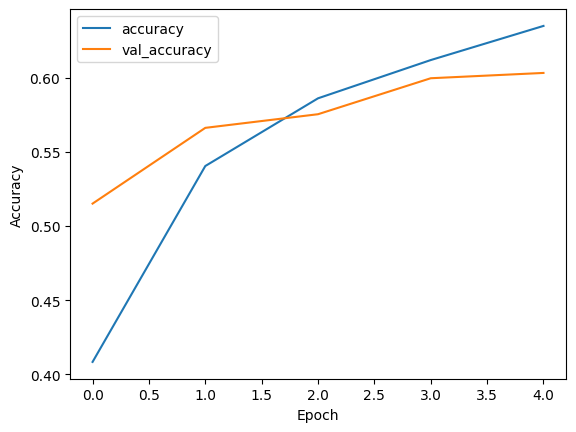

              precision    recall  f1-score   support

           0       0.12      0.05      0.07       388
           1       0.08      0.10      0.09       379
           2       0.09      0.09      0.09       414
           3       0.09      0.09      0.09       411
           4       0.11      0.07      0.09       396
           5       0.08      0.11      0.09       385
           6       0.12      0.14      0.13       393
           7       0.10      0.16      0.12       380
           8       0.10      0.09      0.10       382
           9       0.08      0.05      0.06       390

    accuracy                           0.10      3918
   macro avg       0.10      0.10      0.09      3918
weighted avg       0.10      0.10      0.09      3918



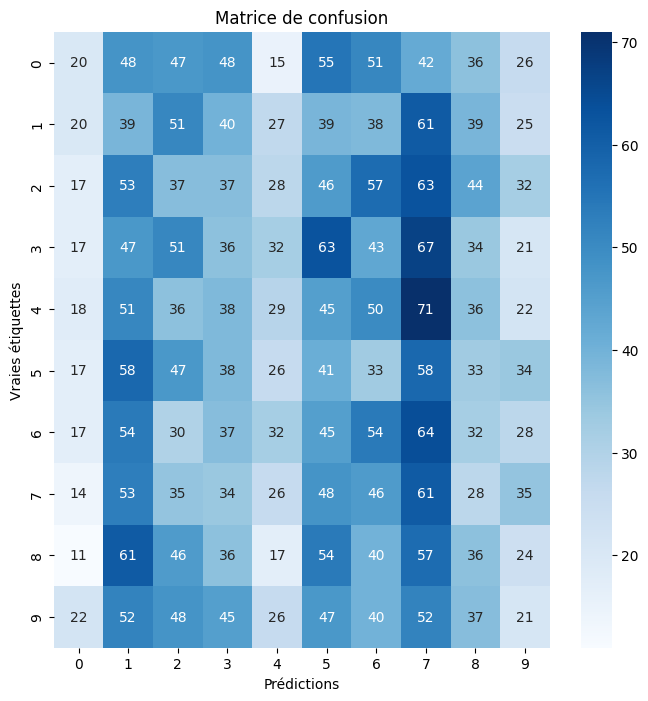

In [20]:
if generator_choice == '1':
  test_loss, test_accuracy = model.evaluate(test_generator)
  y_pred = model.predict(test_generator)

  id_classes = {
    "Agaricales":0,
    "Agaricus":1,
    "Amanita":2,
    "Cortinarius":3,
    "Entoloma":4,
    "Inocybe":5,
    "Mycena":6,
    "Polyporales":7,
    "Psathyrella":8,
    "Russula":9}

  y_true = test_data['label'].replace(id_classes)


else:
  test_loss, test_accuracy = model.evaluate(ds_test)
  y_pred = model.predict(ds_test)
  y_true = ds_test



y_pred_classes = np.argmax(y_pred, axis=1)
print("Test accuracy:", test_accuracy)

# Courbe d'évolution accuracy et val_accuracy lors de l'entrainement
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0,1])
plt.legend()
plt.show()



# Rapport de classification
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred_classes)
print(report)


# Matrice de confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(y_true, y_pred_classes)
# Créer une figure pour afficher la matrice de confusion
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion')
plt.show()

# Sauvegarde du modèle

In [ ]:
model_name

In [ ]:
if work_env == '2':
    model_name = '/content/drive/MyDrive/SAS/model/' + model_name
    history_path = '/content/drive/MyDrive/SAS/history/history.pkl'

else:
    model_name = '../model/' + model_name
    history_path = '../history/history.pkl'


model.save(model_name, save_format='h5')

import pickle
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)